In [21]:
# Importing needed libraries

import pandas as pd
import networkx as nx
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
# Loading dataset
df_final = pd.read_csv("/Users/jangaydoul/Desktop/Copenhagen Business School/4. Semester :: Thesis/03_Data/csvs/df_final.csv")
df_final.head()

,BookingId,SubBookingName,Customer Name,StartRequestedDate,EndRequestedDate,FromLocation,ToLocation,FromLatitude,FromLongitude,FromCity,FromCountry,ToLatitude,ToLongitude,ToCity,ToCountry,DomesticDelivery,route_distance,FullLoadIndicator,EmptyBookingIndicator,GrossWeight,Temperature,frozen_load
0,7399574,A,2966,2020-12-31,2020-12-31,33917,32289,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,1,46.346,1.0,0.0,0.0,NaN,0
1,7399575,A,8183,2020-12-31,2020-12-31,9443,57716,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1,78.192,1.0,0.0,0.0,NaN,0
2,7399576,A,8183,2020-12-31,2020-12-31,9443,57716,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1,78.192,1.0,0.0,0.0,NaN,0
3,7399577,A,4737,2020-12-31,2020-12-31,5977,9831,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,1,17.733,0.0,0.0,0.0,NaN,0
4,7399578,A,4737,2020-12-31,2020-12-31,5977,3182,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,1,369.340,1.0,0.0,0.0,NaN,0


In [23]:
df_final_UK = df_final[(df_final['FromCountry'] == 'United Kingdom') & (df_final['ToCountry'] == 'United Kingdom')]

len(df_final_UK)

1482429

In [24]:
# Filtering for distances < 300km 

df_final_UK_300 = df_final_UK[df_final_UK['route_distance'] < 300]

len(df_final_UK_300)

906595

In [86]:
# Trying folium library

import pandas as pd
import networkx as nx
import folium
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for index, row in df_final_UK_300.iterrows():
    from_location = row['FromLocation']
    to_location = row['ToLocation']
    route_distance = row['route_distance']
    from_lat = row['FromLatitude']
    from_lon = row['FromLongitude']
    to_lat = row['ToLatitude']
    to_lon = row['ToLongitude']

    G.add_node(from_location, latitude=from_lat, longitude=from_lon)
    G.add_node(to_location, latitude=to_lat, longitude=to_lon)
    G.add_edge(from_location, to_location, weight=route_distance)

# Calculate node attributes for pick up and drop off rates
pickup_counts = df_final_UK_300['FromLocation'].value_counts()
dropoff_counts = df_final_UK_300['ToLocation'].value_counts()

for node in G.nodes():
    pickups = pickup_counts.get(node, 0)
    dropoffs = dropoff_counts.get(node, 0)
    total = pickups + dropoffs
    pickup_rate = pickups / total
    dropoff_rate = dropoffs / total
    
    G.nodes[node]['pickup_rate'] = pickup_rate
    G.nodes[node]['dropoff_rate'] = dropoff_rate
    G.nodes[node]['size'] = total

# Create a function to map node colors based on pickup and dropoff rates
def get_node_color(pickup_rate, dropoff_rate):
    pickup_colormap = cm.get_cmap('Reds')
    dropoff_colormap = cm.get_cmap('Blues')
    
    if pickup_rate > dropoff_rate:
        return colors.to_hex(pickup_colormap(pickup_rate))
    else:
        return colors.to_hex(dropoff_colormap(dropoff_rate))

# Create a map centered at the average latitude and longitude of the locations
map_center = df_final_UK_300[['FromLatitude', 'FromLongitude']].mean().tolist()
m = folium.Map(location=map_center, zoom_start=5, tiles="CartoDB Positron")

# Count the number of times each route appears in the data and store it in a dictionary.
route_counts = df_final_UK_300.groupby(['FromLocation', 'ToLocation']).size().to_dict()

# Calculate the top 50% most used routes threshold
threshold = int(len(route_counts) * 0.05)
top_routes = df_final_UK_300.groupby(['FromLocation', 'ToLocation']).size().nlargest(threshold).index.tolist()

# Create a set to store nodes that are part of the top 5% routes
top_route_nodes = {node for route in top_routes for node in route}

# Create a custom colormap or use a built-in one
edge_colormap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["lightblue", "darkblue"])

# Normalize the edge weights based on the minimum and maximum edge weights
min_edge_weight = min(route_counts.values())
max_edge_weight = max(route_counts.values())

# Use logarithmic normalization if the edge weights are heavily skewed
norm = mcolors.LogNorm(vmin=min_edge_weight, vmax=max_edge_weight)

# Iterate through the nodes in the graph
for node in G.nodes():
    latitude = G.nodes[node]['latitude']
    longitude = G.nodes[node]['longitude']
    pickup_rate = G.nodes[node]['pickup_rate']
    dropoff_rate = G.nodes[node]['dropoff_rate']
    node_color = get_node_color(pickup_rate, dropoff_rate)

    if node in top_route_nodes:
        folium.CircleMarker(
            location=[latitude, longitude],
            radius=0.25,
            color=node_color,
            fill=True,
            fill_color=node_color,
            fill_opacity=0.7,
            popup=f"{node}: {pickup_rate:.2f}"
        ).add_to(m)

        # This line should be indented one level deeper
        for _, to_node in G.out_edges(node):
            if to_node in top_route_nodes:
                edge_weight = route_counts.get((node, to_node), 0)

                if (node, to_node) in top_routes:
                    to_location = [G.nodes[to_node]['latitude'], G.nodes[to_node]['longitude']]
                    
                    # Calculate the edge color based on the normalized edge weight
                    edge_color = edge_colormap(norm(edge_weight))

                    folium.PolyLine(
                        locations=[[latitude, longitude], to_location],
                        color=mcolors.to_hex(edge_color),
                        weight=1,
                        opacity=0.5
                    ).add_to(m)


# Save the map to an HTML file
m.save('map_uk_300.html')




In [ ]:
# Count the number of nodes in the graph
num_nodes = G.number_of_nodes()

# Count the number of edges in the graph
num_edges = G.number_of_edges()

print(f"The graph has {num_nodes} nodes and {num_edges} edges.")

In [62]:
#### Try Community Building 

import pandas as pd
import networkx as nx

# Calculate the 'NumDeliveries' for each unique route
df_final_UK_300['route_tuple'] = list(zip(df_final_UK_300['FromLatitude'], df_final_UK_300['FromLongitude'], df_final_UK_300['ToLatitude'], df_final_UK_300['ToLongitude']))
route_counts = df_final_UK_300['route_tuple'].value_counts().reset_index()
route_counts.columns = ['route_tuple', 'NumDeliveries']

# Merge 'NumDeliveries' back into the original dataframe
df_final_UK_300 = df_final_UK_300.merge(route_counts, on='route_tuple', how='left')

# Create a directed, weighted graph
G = nx.DiGraph()

# Add nodes to the graph based on actual coordinates
from_nodes = list(zip(df_final_UK_300['FromLatitude'], df_final_UK_300['FromLongitude']))
to_nodes = list(zip(df_final_UK_300['ToLatitude'], df_final_UK_300['ToLongitude']))
nodes = set(from_nodes + to_nodes)
G.add_nodes_from(nodes)

# Add edges to the graph with 'NumDeliveries' as weight
for index, row in df_final_UK_300.iterrows():
    from_node = (row['FromLatitude'], row['FromLongitude'])
    to_node = (row['ToLatitude'], row['ToLongitude'])
    weight = row['NumDeliveries']
    G.add_edge(from_node, to_node, weight=weight)


/var/folders/c8/h2cp_4sd6dv_l0f506nl_kg00000gn/T/ipykernel_8689/2652311045.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_UK_300['route_tuple'] = list(zip(df_final_UK_300['FromLatitude'], df_final_UK_300['FromLongitude'], df_final_UK_300['ToLatitude'], df_final_UK_300['ToLongitude']))


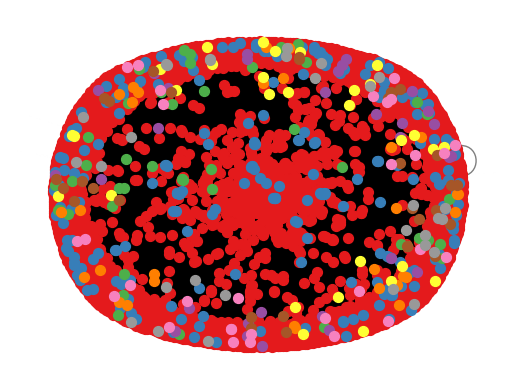

In [75]:
import leidenalg
import igraph as ig

# Create a mapping between NetworkX node labels and integer indices
node_mapping = {node: idx for idx, node in enumerate(G.nodes)}

# Create an empty directed iGraph graph
ig_graph = ig.Graph(directed=True)

# Add nodes to the iGraph graph
ig_graph.add_vertices(list(range(len(G.nodes()))))

# Add edges to the iGraph graph using the mapping
ig_graph.add_edges([(node_mapping[u], node_mapping[v]) for u, v in G.edges()])

# Set the edge weights from the NetworkX graph
ig_graph.es['weight'] = [e['weight'] for _, _, e in G.edges(data=True)]

# Perform community detection using the Leiden algorithm
partition = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)

# Assign communities to nodes
community_labels = {}
for idx, label in enumerate(partition):
    for node in label:
        # Map the iGraph node index back to the original node from the NetworkX graph
        original_node = list(node_mapping.keys())[list(node_mapping.values()).index(node)]
        community_labels[original_node] = idx

# Add community labels as node attributes in the NetworkX graph
for node, community in community_labels.items():
    G.nodes[node]['community'] = community

# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Set up a color map for communities
community_values = [v for k, v in community_labels.items()]
community_unique = list(np.unique(community_values))
colors = plt.cm.Set1(np.linspace(0, 1, len(community_unique)))

# Draw the graph
pos = nx.spring_layout(G)
for community, color in zip(community_unique, colors):
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['community'] == community], node_color=[color], node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrows=True)
plt.axis('off')
plt.show()


